In [1]:
import csv 
import os
import numpy as np
import pickle 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.integrate import odeint
import math
import pandas as pd

## DMD or extended DMD

In [2]:
# Yf and Yp and Up have each column reserved for observable and each row for time
def calc_Koopman(Yf,Yp):
    
    K = np.dot(Yf,np.linalg.pinv(Yp))
    return(K)


def nCk(n,k):
    f = np.math.factorial
    return f(n) / f(k) / f(n-k)


def build_monomial_dictionary(data,polyorder):

    numStates = data.shape[1]
    numTimepts = data.shape[0]
    
    if polyorder > numStates:
        print('Dictionary has not been built because polyorder cannot be greater than number of states.')
        return
    
    if polyorder == 1:
        numCols_psi = 1 + polyorder*numStates 
    elif polyorder == 2:    
        numCols_psi = 1 + polyorder*numStates + nCk(numStates,polyorder)
    elif polyorder == 3:    
        numCols_psi = 1 + polyorder*numStates + nCk(numStates,polyorder) + nCk(numStates,polyorder-1)
    elif polyorder == 4:    
        numCols_psi = 1 + polyorder*numStates + nCk(numStates,polyorder) + nCk(numStates,polyorder-1) + nCk(numStates,polyorder-2)  
    elif polyorder == 5:
        numCols_psi = 1 + polyorder*numStates + nCk(numStates,polyorder) + nCk(numStates,polyorder-1) + nCk(numStates,polyorder-2) + nCk(numStates,polyorder-3)  
    
    numCols_psi = np.int(numCols_psi)
    psi = np.zeros((numTimepts,numCols_psi))
    
    ind = 1
    # polyorder 0
    psi[:,ind-1:ind] = np.ones((numTimepts,1))
    
    ind = ind + 1
    # polyorder 1
    for i in range(1,numStates+1):
        psi[:,ind-1:ind] = data[:,i-1:i];
        ind = ind + 1;

    if polyorder >= 2:
        # polyorder 2
        for i in range(1,numStates+1):
            for j in range(i,numStates+1):
                psi[:,ind-1:ind] = data[:,i-1:i]*data[:,j-1:j];
                ind = ind + 1;

    if polyorder >= 3:
        # polyorder 3
        for i in range(1,numStates+1):
            for j in range(i,numStates+1):
                for k in range(j,numStates+1):
                    psi[:,ind-1:ind] = data[:,i-1:i]*data[:,j-1:j]*data[:,k-1:k];
                    ind = ind + 1;

    if polyorder >= 4:
        # polyorder 4
        for i in range(1,numStates+1):
            for j in range(i,numStates+1):
                for k in range(j,numStates+1):
                    for l in range(k,numStates+1):
                        psi[:,ind-1:ind] = data[:,i-1:i]*data[:,j-1:j]*data[:,k-1:k]*data[:,l-1:l];
                        ind = ind + 1;

    if polyorder >= 5:
        # polyorder 5
        for i in range(1,numStates+1):
            for j in range(i,numStates+1):
                for k in range(j,numStates+1):
                    for l in range(k,numStates+1):
                        for m in range(l,numStates+1):
                            psi[:,ind-1:ind] = data[:,i-1:i]*data[:,j-1:j]*data[:,k-1:k]*data[:,l-1:l]*data[:,m-1:m];
                            ind = ind + 1;

    return(psi)

## DMD with input

In [3]:
def calc_Input_Koopman(Yf,Yp,Up,X):
    # Yf and Yp and Up have each column reserved for observable and each row for time
    
    V = np.vstack((Yf,X)) @ np.transpose(np.vstack((Yp, Up)))
    G = np.vstack((Yp,Up)) @ np.transpose(np.vstack((Yp,Up)))
    M = V @ np.linalg.pinv(G)
    
    return M;

# trp pathway ODEs

In [4]:
def S(conc):
    
    S = 1/(1+np.exp(-conc))
    
    return S

numRates = 52
k = np.random.normal(loc=0.3,scale=0.09,size=numRates) # "ideal" conditions
# k = np.random.normal(loc=1,scale=0.1,size=numRates) # "uncertain" conditions
def trp(x,t): 
    
    # concentration 
    
    # define constants
    h2o = 90.8
    glu = 70.6
    pyr = 70.9
    hplus = 80.2
    dip = 80.5
    co2 = 60.7
    
    # rename states
    cha = x[0]
    gln = x[1]
    anth = x[2]
    fivepa = x[3]
    nfivepa = x[4]
    onetwoc = x[5]
    onetwosr = x[6] # should have been named onestwor
    ind = x[7]
    ser = x[8]
    trp = x[9]
    e1 = x[10]
    e2 = x[11]
    e3 = x[12]
    e4 = x[13]
    e5 = x[14]
    e6 = x[15]
    cha_e1 = x[16]
    gln_e1 = x[17]
    anth_e2 = x[18]
    fivepa_e2 = x[19]
    nfivepa_e3 = x[20]
    onetwoc_e4 = x[21]
    onetwosr_e5 = x[22]
    ind_e6 = x[23]
    ser_e6 = x[24]
    dg3p = x[25]
    trpR = x[26]
    trp_trpR = x[27]
    gRNA1 = x[28]
    gRNA2 = x[29]
    gRNA3 = x[30]
    gRNA4 = x[31]
    gRNA5 = x[32]
    gRNA6 = x[33]
    gRNA1_dCas9 = x[34]
    gRNA2_dCas9 = x[35]
    gRNA3_dCas9 = x[36]
    gRNA4_dCas9 = x[37]
    gRNA5_dCas9 = x[38]
    gRNA6_dCas9 = x[39]
    dCas9 = x[40]
    
    a = 0.5
    kg = 0.5
    kt = 0.5
    a1 = a/(1+(gRNA1_dCas9)/kg+(trp_trpR)/kt) # production rates of enzymes
    a2 = a/(1+(gRNA2_dCas9)/kg+(trp_trpR)/kt)
    a3 = a/(1+(gRNA3_dCas9)/kg+(trp_trpR)/kt)
    a4 = a/(1+(gRNA4_dCas9)/kg+(trp_trpR)/kt)
    a5 = a/(1+(gRNA5_dCas9)/kg+(trp_trpR)/kt)
    a6 = a/(1+(gRNA6_dCas9)/kg+(trp_trpR)/kt)
    de = 1
    aR = 0.5
    dR = 0.075  # assumes 30 min doubling time, rates are in terms of hours
    ag = 0.3
    dg = 0.025
    ad = 0.56
    dd = 0.075
    
    dcha = (-k[0]*cha*gln-k[1]*cha*e1+k[2]*cha_e1-k[7]*cha*gln_e1)
    dgln = (-k[0]*cha*gln-k[3]*gln*e1+k[4]*gln_e1-k[6]*cha_e1*gln)
    danth = (k[0]*cha*gln+k[5]*cha_e1*gln_e1+k[6]*cha_e1*gln+k[7]*cha*gln_e1-k[8]*
            anth*fivepa-k[9]*anth*e2+k[10]*anth_e2-k[15]*anth*fivepa_e2-0.05)
    dfivepa = (-k[8]*anth*fivepa-k[11]*fivepa*e2+k[12]*fivepa_e2-k[14]*anth_e2*fivepa)
    dnfivepa = (k[8]*anth*fivepa+k[13]*anth_e2*fivepa_e2+k[14]*anth_e2*fivepa+k[15]
               *anth*fivepa_e2-k[16]*nfivepa-k[17]*nfivepa*e3)
#     if dnfivepa>1e2:
#         print("k[8]*anth*nfivepa:" + repr(k[8]*anth*nfivepa))
#         print("2nd term:" + repr(k[13]*anth_e2*fivepa_e2))
#         print("3rd term:" + repr(k[14]*anth_e2*fivepa))
#         print("4th term:" + repr(k[15]*anth*fivepa_e2))
#         print("5th term:"+repr(k[16]*nfivepa))
#         print("6th term:" + repr(k[17]*nfivepa*e3))
#         print("7th term:" + repr(k[19]*nfivepa_e3))
    
    donetwoc = (k[16]*nfivepa+k[19]*nfivepa_e3-k[20]*onetwoc*hplus-k[21]*onetwoc*e4+k[22]
               *onetwoc_e4)
    donetwosr = (-k[24]*onetwosr+k[25]*dg3p*ind-k[26]*onetwosr*e5+k[27]*onetwosr_e5 + 
                 k[20]*onetwoc*hplus +k[23]*onetwoc_e4*hplus)
    dind = (k[24]*onetwosr-k[25]*dg3p*ind+k[28]*onetwosr_e5-k[29]*e5*dg3p*ind-k[30]*ind
           *ser-k[31]*ind*e6+k[32]*ind_e6-k[37]*ind*ser_e6)
    dser = (-k[30]*ind*ser-k[33]*ser*e6+k[34]*ser_e6-k[36]*ind_e6*ser)
    dtrp = (k[30]*ind*ser+k[35]*ind_e6*ser_e6+k[36]*ind_e6*ser+k[37]*ind*ser_e6)
    de1 = (-k[1]*cha*e1+k[2]*cha_e1-k[3]*gln*e1+k[4]*gln_e1+k[5]*cha_e1*gln_e1+k[6]
          *cha_e1*gln+k[7]*cha*gln_e1+a1-S(trp)*trp-de*e1)
    de2 = (-k[9]*anth*e2+k[10]*anth_e2-k[11]*fivepa*e2+k[12]*fivepa_e2+k[13]*anth_e2
          *fivepa_e2+k[14]*anth_e2*fivepa+k[15]*anth*fivepa_e2+a2-S(trp)*trp-de*e2)
    de3 = (-k[17]*nfivepa*e3+k[18]*nfivepa_e3+k[19]*nfivepa_e3+a3-S(trp)*trp-de*e3)
    de4 = (-k[21]*onetwoc*e4+k[22]*onetwoc_e4+k[23]*onetwoc_e4*hplus+a4-S(trp)*trp-de*e4)
    de5 = (-k[26]*onetwosr*e5+k[27]*onetwosr_e5+k[28]*onetwosr_e5+a5-S(trp)*trp-de*e5)
    de6 = (-k[31]*ind*e6+k[32]*ind_e6-k[33]*ser*e6+k[34]*ser_e6+k[35]*ind_e6*ser_e6
           +k[36]*ind_e6*ser+k[37]*ind*ser_e6+a6-S(trp)*trp-de*e6)
    dcha_e1 = (k[1]*cha*e1-k[2]*cha_e1-k[5]*cha_e1*gln_e1-k[6]*cha_e1*gln)
    dgln_e1 = (k[3]*gln*e1-k[4]*gln_e1-k[5]*cha_e1*gln_e1-k[7]*cha*gln_e1)
    danth_e2 = (k[9]*anth*e2-k[10]*anth_e2-k[13]*anth_e2*fivepa_e2-k[14]*anth_e2*fivepa+0.05)
    dfivepa_e2 = (k[11]*fivepa*e2-k[12]*fivepa_e2-k[13]*anth_e2*fivepa_e2-k[15]*anth
                  *fivepa_e2)
    dnfivepa_e3 = (k[17]*nfivepa*e3-k[18]*nfivepa_e3-k[19]*nfivepa_e3)
    donetwoc_e4 = (k[21]*onetwoc*e4-k[22]*onetwoc_e4-k[23]*onetwoc_e4*hplus)
    donetwosr_e5 = (k[26]*onetwosr*e5-k[27]*onetwosr_e5-k[28]*onetwosr_e5+k[29]*e5*dg3p*ind)
    dind_e6 = (k[31]*ind*e6-k[32]*ind_e6-k[35]*ind_e6*ser_e6-k[36]*ind*ser_e6)
    dser_e6 = (k[33]*ser*e6 - k[34]*ser_e6-k[35]*ind_e6*ser_e6-k[37]*ind*ser_e6)
    ddg3p = k[28]*onetwosr_e5+k[24]*onetwosr-k[25]*dg3p*ind-0.5*dg3p
    dtrpR = -k[38]*trpR*trp+k[39]*trp_trpR+aR-dR*trpR
    dtrp_trpR = k[38]*trpR*trp-k[39]*trp_trpR
    
    # adjusting parameters to affect bionumbers 6 hr correction - https://bionumbers.hms.harvard.edu/Search.aspx?trm=dCas9
    k[40:52] = k[40:52]#/(6.0)
    
    dgRNA1 = -k[40]/5*gRNA1*dCas9+k[41]*gRNA1_dCas9+ag-dg*gRNA1
    dgRNA2 = -k[42]/5*gRNA2*dCas9+k[43]*gRNA2_dCas9+ag-dg*gRNA2
    dgRNA3 = -k[44]/5*gRNA3*dCas9+k[45]*gRNA3_dCas9+ag-dg*gRNA3
    dgRNA4 = -k[46]/5*gRNA4*dCas9+k[47]*gRNA4_dCas9+ag-dg*gRNA4
    dgRNA5 = -k[48]/5*gRNA5*dCas9+k[49]*gRNA5_dCas9+ag-dg*gRNA5
    dgRNA6 = -k[50]/5*gRNA6*dCas9+k[51]*gRNA6_dCas9+ag-dg*gRNA6
    dgRNA1_dCas9 = k[40]/5*gRNA1*dCas9-k[41]*gRNA1_dCas9
    dgRNA2_dCas9 = k[42]/5*gRNA2*dCas9-k[43]*gRNA2_dCas9
    dgRNA3_dCas9 = k[44]/5*gRNA3*dCas9-k[45]*gRNA3_dCas9
    dgRNA4_dCas9 = k[46]/5*gRNA4*dCas9-k[47]*gRNA4_dCas9
    dgRNA5_dCas9 = k[48]/5*gRNA5*dCas9-k[49]*gRNA5_dCas9
    dgRNA6_dCas9 = k[50]/5*gRNA6*dCas9-k[51]*gRNA6_dCas9
    ddCas9 = (k[41]*gRNA1_dCas9+k[43]*gRNA2_dCas9+k[45]*gRNA3_dCas9+k[47]*gRNA4_dCas9+
             k[49]*gRNA5_dCas9+k[51]*gRNA6_dCas9-k[40]/5*gRNA1*dCas9-k[42]/5*gRNA2*dCas9
              -k[44]/5*gRNA3*dCas9-k[46]/5*gRNA4*dCas9-k[48]/5*gRNA5*dCas9-k[50]/5*gRNA6*dCas9
              +ad-dd*dCas9)
    
    return ([dcha,dgln,danth,dfivepa,dnfivepa,donetwoc,donetwosr,dind,dser,dtrp,de1,de2,de2,\
          de4,de5,de6,dcha_e1,dgln_e1,danth_e2,dfivepa_e2,dnfivepa_e3,donetwoc_e4,\
          donetwosr_e5,dind_e6,dser_e6,ddg3p,dtrpR,dtrp_trpR,dgRNA1,dgRNA2,dgRNA3,\
            dgRNA4,dgRNA5,dgRNA6,dgRNA1_dCas9,dgRNA2_dCas9,dgRNA3_dCas9,dgRNA4_dCas9,\
            dgRNA5_dCas9,dgRNA6_dCas9,ddCas9])
    

# solve the ODEs

In [5]:
# IC_perm = IC;
# pickle.dump([IC_perm],open('Initial_Trp_Pn.pickle','wb'))

In [6]:
numStates = 41

# IC = 0.1*np.ones(numStates)
IC = np.random.normal(loc=0.15,scale=0.02,size=numStates)   

IC[0] = IC[0]*1e1; # nM 
IC[1] = IC[1]*1e1; # nM 
IC[[2,4,5,6,7,9]] =0.0; #all other chemicals 
IC[10:16] = IC[10:16]*10.0 # nM 
IC[16:25] = IC[16:25]*0.0; # no starting catalytic complexes
IC[25] = IC[25]*1e3 #nM // side reactant
IC[26] = IC[26]*10 # nM // protein
IC[28:34] = IC[28:34]*1e1; #nM 
IC[34:40] = 0.0;
IC[40]=IC[40]*1e1 # lots of dCas9 protein 

tStart = 0.0
tEnd = 300
Nt = tEnd
tSpan = np.linspace(tStart,tEnd,75)

x_states = odeint(trp,IC,tSpan)
u_inputs = x_states[:,28:]
x_states = x_states[:,0:28] 

x_cha = x_states[:,0]
x_gln = x_states[:,1]
x_anth = x_states[:,2]
x_fivepa = x_states[:,3]
x_nfivepa = x_states[:,4]
x_onetwoc = x_states[:,5]
x_onetwosr = x_states[:,6]
x_ind = x_states[:,7]
x_ser = x_states[:,8]
x_trp = x_states[:,9]
x_e1 = x_states[:,10]
x_e2 = x_states[:,11]
x_e3 = x_states[:,12]
x_e4 = x_states[:,13]
x_e5 = x_states[:,14]
x_e6 = x_states[:,15]
x_cha_e1 = x_states[:,16]
x_gln_e1 = x_states[:,17]
x_anth_e2 = x_states[:,18]
x_fivepa_e2 = x_states[:,19]
x_nfivepa_e3 = x_states[:,20]
x_onetwoc_e4 = x_states[:,21]
x_onetwosr_e5 = x_states[:,22]
x_ind_e6 = x_states[:,23]
x_ser_e6 = x_states[:,24]
x_dg3p = x_states[:,25]
x_trpR = x_states[:,26]
x_trp_trpR = x_states[:,27]
u_gRNA1 = u_inputs[:,0]
u_gRNA2 = u_inputs[:,1]
u_gRNA3 = u_inputs[:,2]
u_gRNA4 = u_inputs[:,3]
u_gRNA5 = u_inputs[:,4]
u_gRNA6 = u_inputs[:,5]
u_gRNA1_dCas9 = u_inputs[:,6]
u_gRNA2_dCas9 = u_inputs[:,7]
u_gRNA3_dCas9 = u_inputs[:,8]
u_gRNA4_dCas9 = u_inputs[:,9]
u_gRNA5_dCas9 = u_inputs[:,10]
u_gRNA6_dCas9 = u_inputs[:,11]
u_dCas9 = u_inputs[:,12]

for i in range(x_states.shape[0]):
    for j in range(x_states.shape[1]):
        if x_states[i,j] < -0.0001:
            print(str(i)+','+str(j)+'warning: there cannot be negative concentrations in states!')

    
for i in range(u_inputs.shape[0]):
    for j in range(u_inputs.shape[1]):
        if u_inputs[i,j] < -0.0001:
            print('warning: there cannot be negative concentrations in inputs!')
 
    

1,12warning: there cannot be negative concentrations in states!
1,20warning: there cannot be negative concentrations in states!
2,12warning: there cannot be negative concentrations in states!
2,20warning: there cannot be negative concentrations in states!
3,12warning: there cannot be negative concentrations in states!
3,20warning: there cannot be negative concentrations in states!
4,12warning: there cannot be negative concentrations in states!
4,20warning: there cannot be negative concentrations in states!
5,12warning: there cannot be negative concentrations in states!
5,20warning: there cannot be negative concentrations in states!
6,12warning: there cannot be negative concentrations in states!
6,20warning: there cannot be negative concentrations in states!
7,12warning: there cannot be negative concentrations in states!
8,12warning: there cannot be negative concentrations in states!
9,12warning: there cannot be negative concentrations in states!
10,12warning: there cannot be negative c

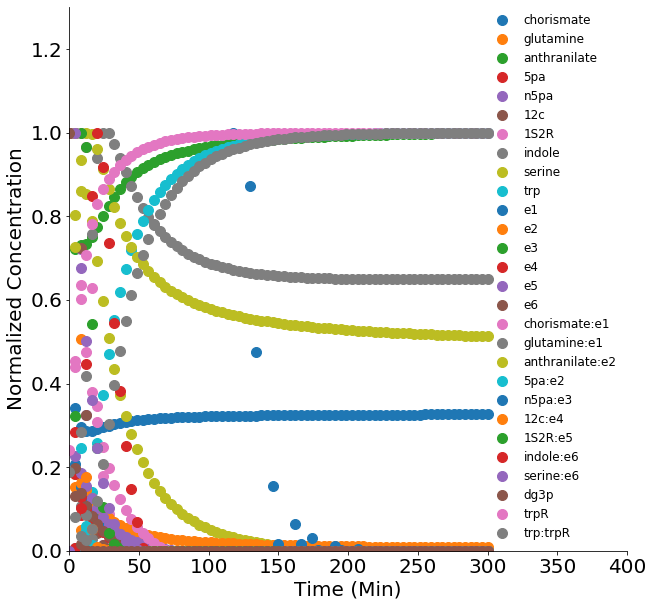

In [7]:

import matplotlib 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('font',family='sans serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

xlabels = ['cha','gln','anth','fivepa','nfivepa','onetwoc','onetwosr','ind','ser','trp',\
          'e1','e2','e3','e4','e5','e6','cha_e1','gln_e1','anth_e2','fivepa_e2',\
          'nfivepa_e3','onetwoc_e4','onetwosr_e5','ind_e6','ser_e6','dg3p','trpR','trp_trpR']

xlabels = ['chorismate','glutamine','anthranilate','5pa','n5pa','12c','1S2R','indole','serine','trp',\
          'e1','e2','e3','e4','e5','e6','chorismate:e1','glutamine:e1','anthranilate:e2','5pa:e2',\
          'n5pa:e3','12c:e4','1S2R:e5','indole:e6','serine:e6','dg3p','trpR','trp:trpR']

plt.figure(figsize=(10,10))

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)


# plot concentration over time for all states
for i in range(0,x_states.shape[1]):
    plt.plot(tSpan,x_states[:,i]/np.max(x_states[:,i]),'.',ms=20)
    plt.xlabel('Time (Min)',size=20)
    plt.ylabel('Normalized Concentration',size=20)
    plt.xlim([0,400])
    plt.ylim([0,1.3])
    #plt.title(xlabels[i])
plt.legend(xlabels,frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

save_results_to = '/Users/aqib/Desktop/UCSB/Research/BCCL/Koopman_SS_prog/Yeung_Mod_AH_NB_Code/figures/'
plt.savefig(save_results_to + 'state_conc_over_time.pdf',bbox_inches='tight')



In [ ]:
x_trp

In [ ]:
plt.figure(figsize=(10,10))
# plt.plot(tSpan,x_anth_e2/np.max(x_anth_e2),'.',ms=20)
plt.plot(tSpan,x_trp,'.',ms=20)
# plt.plot(tSpan,x_ser_e6/np.max(x_ser_e6),'.',ms=20)
# plt.plot(tSpan,x_anth/np.max(x_anth),'.',ms=20)

In [ ]:
ulabels = ['dgRNA1','dgRNA2','dgRNA3','dgRNA4','dgRNA5','dgRNA6','dgRNA1_dCas9','dgRNA2_dCas9',\
           'dgRNA3_dCas9','dgRNA4_dCas9','dgRNA5_dCas9','dgRNA6_dCas9','dCas9']  

# # plot concentration over time for all inputs
# for i in range(0,u_inputs.shape[1]):
#     plt.figure()
#     plt.plot(tSpan,u_inputs[:,i])
#     plt.xlabel('Time')
#     plt.ylabel('Concentration')
# #     plt.xlim([0,50])
# #     plt.ylim([0,0.4])
#     plt.title(ulabels[i])

# plt.figure(figsize=(10,10))

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# plot concentration over time for all states
for i in range(0,u_inputs.shape[1]):
    plt.plot(tSpan,u_inputs[:,i]/np.max(u_inputs[:,i]),'.',ms=10)
    plt.xlabel('Time (Min)',size=20)
    plt.ylabel('Normalized Concentration',size=20)
    plt.xlim([0,500])
    plt.ylim([0,3.5])
    #plt.title(xlabels[i])
plt.legend(ulabels,frameon=False,ncol=2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

    
    

## save data to pickle file

In [ ]:
x_states.shape

In [ ]:

subsample = list(range(0,74,1))#[0,6,12,18,24,30,36,42,48,54,60,66,74];

In [ ]:
flag_koopman_data = 1
if flag_koopman_data == 1:
    Yp = x_states[subsample[0:-1],:]
    Yf = x_states[subsample[1:],:]
    Up = u_inputs[subsample[0:-1],6:12]
#     Yp = x_states[0:x_states.shape[0]-1,:]
#     Yf = x_states[1:x_states.shape[0],:]
#     Up = u_inputs[0:u_inputs.shape[0]-1,6:12] # the actual inputs for Koopman DMD are only the gRNAi:dCas9 compound
    # Ypickle = np.zeros((2,x_states.shape[0]-1,x_states.shape[1]))
    # Ypickle[0] = Yp
    # Ypickle[1] = Yf
    pickle_out = open("trp_input.pickle","wb")
    pickle.dump([Yp,Yf,Up], pickle_out)
    pickle_out.close()

flag_rr_ic_data = 1
if flag_rr_ic_data == 1:
    pickle_out2 = open('RRs_ICs_trp_input.pickle','wb')
    pickle.dump([k,IC], pickle_out2)
    pickle_out2.close()

## DMD

In [ ]:
#print(np.transpose(PsiYf.shape))
print(np.transpose(Yp.shape))

In [ ]:
PsiYp = build_monomial_dictionary(Yp,1)
PsiYf = build_monomial_dictionary(Yf,1)
# print(PsiYp.shape)
# print(PsiYp.shape)
K = calc_Input_Koopman(np.transpose(Yf),np.transpose(Yp),np.transpose(Up),np.transpose(Yp))
print(K.shape)

In [ ]:
K_x = K[0:Yp.shape[1],0:Yp.shape[1]]
print(K_x.shape)
K_u = K[0:Yp.shape[1],K_x.shape[1]:]
print(K_u.shape)

In [ ]:
plt.figure()
sns.heatmap(K_x,cmap='RdYlGn')
plt.figure()
sns.heatmap(K_u,cmap='RdYlGn')

In [ ]:
pickle_out4= open("trp_Kx_Ku.pickle",'wb')
pickle.dump([K_x,K_u],pickle_out4)
pickle_out4.close()

In [ ]:
K_u.shape

In [ ]:
plt.figure(figsize=(7,7))
sns.heatmap(np.matmul(np.linalg.inv(np.eye(K_x.shape[0])-K_x),K_u),cmap='RdYlGn')

In [ ]:
sns.heatmap(K_u)

In [ ]:
P_x = 0.0*np.zeros(shape=(1,K_x.shape[0]))
P_x[0,9] = 1.0; 
P_x

In [ ]:
from cvxpy import Minimize
from cvxpy import Minimize, Problem, Variable,norm1,installed_solvers,lambda_max;
from cvxpy import norm as cvxpynorm;
import cvxpy


optimal_u = Variable(shape=(K_u.shape[1],1))

optimal_trp= P_x*(np.matmul(np.linalg.inv(np.eye(K_x.shape[0]) - K_x),K_u)*optimal_u);
objective = Minimize(cvxpy.sum(-P_x *(np.matmul(np.linalg.inv(np.eye(K_x.shape[0]) - K_x),K_u)*optimal_u)))
constraints =[optimal_u>=0 ,25>=optimal_u]
prob = Problem(objective, constraints)
result = prob.solve(verbose=True)#(solver=solver_instance);
print(prob.status);

optimal_u_val = optimal_u.value ;
optimal_u_val[np.abs(optimal_u_val)<1e-5] = 0;
print("Optimal gRNA concentration:" + repr(optimal_u_val))
print("objective value: " +repr(objective.value))
print("optimal Trp value: " + repr(optimal_trp.value[0][0]))
#

In [ ]:
# import ideal condition Koopman operators
output_vec = pickle.load(open('trp_Kx_Ku_ideal.pickle','rb'));
K_x_ideal = output_vec[0]
K_u_ideal = output_vec[1]


In [ ]:
# testing to see what happens if we use original model on perturbed data

from cvxpy import Minimize
from cvxpy import Minimize, Problem, Variable,norm1,installed_solvers,lambda_max;
from cvxpy import norm as cvxpynorm;
import cvxpy

optimal_u = Variable(shape=(K_u_ideal.shape[1],1))

optimal_trp= P_x*(np.matmul(np.linalg.inv(np.eye(K_x_ideal.shape[0]) - K_x_ideal),K_u_ideal)*optimal_u);
objective = Minimize(cvxpy.sum(-P_x *(np.matmul(np.linalg.inv(np.eye(K_x_ideal.shape[0]) - K_x_ideal),K_u_ideal)*optimal_u)))
constraints =[optimal_u>=0 ,25>=optimal_u]
prob = Problem(objective, constraints)
result = prob.solve(verbose=True)#(solver=solver_instance);
print(prob.status);

optimal_u_val = optimal_u.value ;
optimal_u_val[np.abs(optimal_u_val)<1e-5] = 0;
print("Optimal gRNA concentration:" + repr(optimal_u_val))
print("objective value: " +repr(objective.value))
print("optimal Trp value: " + repr(optimal_trp.value[0][0]))